[Dmaziuk's page](https://github.com/dmaziuk/diy-zhl/blob/master/diyzhl.ipynb)

[Introductory Deco Lessons](https://www.shearwater.com/wp-content/uploads/2012/08/Introductory-Deco-Lessons.pdf)

[Understanding M-values](https://www.frogkick.nl/files/understanding_m-values.pdf)

[DIY deco](http://www.lizardland.co.uk/DIYDeco.html)

# Schreiner Equation
## Fundamental equation of the dissolved gas

$\frac{dP}{dt} = k(P_i - P)$

For ascent or descent at a constant rate, this resolves:

$P = P_{i,0}+R\left(t-\frac{1}{k}\right)-\left[P_{i,0}-P_0-\frac{R}{k}\right]e^{-kt}$
- $P$ Final compartment inert gas pressure
- $P_{i,0}$ Initial ambient pressure
- $P_0$ Initial compartment inert gas pressure
- $R$ rate of change in inspired gas pressure with change in ambient pressure
- $t$ time
- $k$ $\frac{ln(2)}{\lambda}$
- $\lambda$: half time

We define the ZHL-16C coefficients

In [1]:
from buhlmann import ZHL_16C

from prettytable import PrettyTable

def generate_ascii_table(df):
    x = PrettyTable()
    x.field_names = df.columns.tolist()
    for row in df.values:
        x.add_row(row)
    print(x)
    return x

generate_ascii_table(ZHL_16C)

+-------------+-------------+--------+--------+-------------+--------+--------+
| compartment | n2_halflife |  n2_a  |  n2_b  | he_halflife |  he_a  |  he_b  |
+-------------+-------------+--------+--------+-------------+--------+--------+
|     1.0     |     5.0     | 1.1696 | 0.5578 |     1.88    | 1.6189 | 0.477  |
|     2.0     |     8.0     |  1.0   | 0.6514 |     3.02    | 1.383  | 0.5747 |
|     3.0     |     12.5    | 0.8618 | 0.7222 |     4.72    | 1.1919 | 0.6527 |
|     4.0     |     18.5    | 0.7562 | 0.7825 |     6.99    | 1.0458 | 0.7223 |
|     5.0     |     27.0    |  0.62  | 0.8126 |    10.21    | 0.922  | 0.7582 |
|     6.0     |     38.3    | 0.5043 | 0.8434 |    14.48    | 0.8205 | 0.7957 |
|     7.0     |     54.3    | 0.441  | 0.8693 |    20.53    | 0.7305 | 0.8279 |
|     8.0     |     77.0    |  0.4   | 0.891  |    29.11    | 0.6502 | 0.8553 |
|     9.0     |    109.0    | 0.375  | 0.9092 |     41.2    | 0.595  | 0.8757 |
|     10.0    |    146.0    |  0.35  | 0

Surface pressure is assumed to be 1 bar
Water Vapour Pressure in Alveolies is expressed in bars

In [2]:
# in bar
SURFACE_PRESSURE = 1
WATER_VAPOR_PRESSURE_ALVEOLI = 0.0567

# in fsw
# SURFACE_PRESSURE = 33
# WATER_VAPOR_PRESSURE_ALVEOLI = 2.042


# 1st dive so 0.79 N2 and 0 HE
surface_n2_pp = 0.79


Define a gas for the dive

In [3]:
from buhlmann import Gas, Tissues
# gas = Gas(n2_pc=0.4, he_pc=0.45)
gas = Gas(n2_pc=0.79, he_pc=0.0)

tissues = Tissues()
print("Initial N2 partial pressure: {}".format(tissues.n2_p))
print("Initial He partial pressure: {}".format(tissues.he_p))

Initial N2 partial pressure: <PandasArray>
[0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001, 0.7452070000000001, 0.7452070000000001,
 0.7452070000000001]
Length: 16, dtype: float64
Initial He partial pressure: <IntegerArray>
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Length: 16, dtype: Int64


let's try a dive

In [4]:
from buhlmann import get_partial_pressures, ceiling, pressure_to_depth, depth_to_pressure

dive = [
    (0, 0),
    (2, 40),    # 40 meters at 2 mins
    (22, 40),   # 40 meters at 22 mins
]
initial_tissues = Tissues()
print("initial ceiling: {}".format(pressure_to_depth(ceiling(tissues))))

initial ceiling: -5.052769928999999


We can compute the ceilings like this:

In [5]:
tissues = initial_tissues
for i_step, ((start_time, start_depth), (end_time, end_depth)) in enumerate(zip(dive[:-1], dive[1:])):
    print("Step:{}, t_start={}, depth_start={}, t_end={}, depth_end={}".format(
        i_step, start_time, start_depth, end_time, end_depth
    ))
    tissues = get_partial_pressures(
            tissues,        # vector for compartments
            gas,
            depth_to_pressure(start_depth),    # for example 0 feet
            depth_to_pressure(end_depth),      # for example 120 feet
            end_time-start_time,              # time for depth change
    )
    print("ceiling: {}".format(pressure_to_depth(ceiling(tissues))))

Step:0, t_start=0, depth_start=0, t_end=2, depth_end=40
ceiling: -5.019497451499991
Step:1, t_start=2, depth_start=40, t_end=22, depth_end=40
ceiling: 5.5835348059744145


We try to find the stops for the dive

In [8]:
dive_w_stops = dive
from buhlmann import find_next_stop

current_depth = end_depth
while current_depth != 0:
    print("Find stops for depth={}".format(current_depth))
    stop_info = find_next_stop(tissues, current_depth, gas, 9)

    # update the times
    stop_info = [ (t + dive[-1][0], d) for (t, d) in stop_info]
    print("STOPS={}".format(stop_info))

    # update tissues
    schedule = [ dive[-1]] + stop_info

    for (start_time, start_depth), (end_time, end_depth) in zip(schedule[:-1], schedule[1:]):

        tissues = get_partial_pressures(
                tissues,        # vector for compartments
                gas,
                depth_to_pressure(start_depth),    # for example 0 feet
                depth_to_pressure(end_depth),      # for example 120 feet
                end_time-start_time,              # time for depth change
        )

    # append to the dive
    dive_w_stops.extend(stop_info)

    current_depth = dive_w_stops[-1][1]

print("Final Dive Plan={}".format(dive_w_stops))
# we put this functionality in buhlmann.get_stops_to_surface()


Final Dive Plan=[(0, 0), (2, 40), (22, 40), (26, 6), (40, 6), (41, 0)]


But to display a graph we will do this

       t  depth   ceiling
0    0.0    0.0 -5.052770
1    1.0   20.0 -5.044449
2    2.0   40.0 -5.019497
3    3.0   40.0 -4.986255
4    4.0   40.0 -4.953049
5    5.0   40.0 -4.896996
6    6.0   40.0 -3.582280
7    7.0   40.0 -2.437754
8    8.0   40.0 -1.441385
9    9.0   40.0 -0.573996
10  10.0   40.0  0.181110
11  11.0   40.0  0.838468
12  12.0   40.0  1.410731
13  13.0   40.0  1.908915
14  14.0   40.0  2.342610
15  15.0   40.0  2.797127
16  16.0   40.0  3.305676
17  17.0   40.0  3.772017
18  18.0   40.0  4.199654
19  19.0   40.0  4.591799
20  20.0   40.0  4.951397
21  21.0   40.0  5.281150
22  22.0   40.0  5.583535
23  23.0   31.5  5.676684
24  24.0   23.0  5.399065
25  25.0   14.5  4.799980
26  26.0    6.0  4.270459
27  27.0    6.0  3.639913
28  28.0    6.0  3.043380
29  29.0    6.0  2.479025
30  30.0    6.0  2.080933
31  31.0    6.0  1.769900
32  32.0    6.0  1.470306
33  33.0    6.0  1.181729
34  34.0    6.0  0.903763
35  35.0    6.0  0.636020
36  36.0    6.0  0.459209
37  37.0    

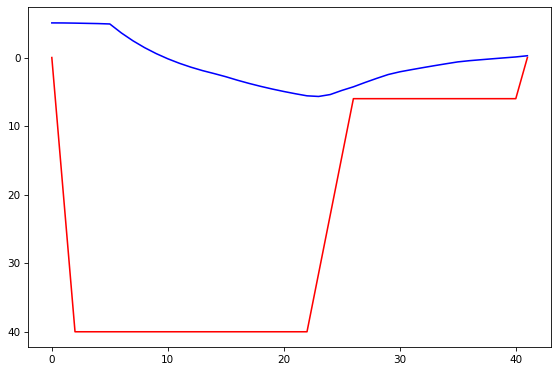

In [9]:
import pandas as pd
tissues = initial_tissues

dive_data = pd.DataFrame([
],
    columns=['t',
             'depth',
             'ceiling']
)
# initial point
dive_data.loc[len(dive_data)] = [0, 0, pressure_to_depth(ceiling(tissues))]
t_resolution = 1
for i_step, ((start_time, start_depth), (end_time, end_depth)) in enumerate(zip(dive_w_stops[:-1], dive_w_stops[1:])):
    start_tissues = tissues
    t = start_time + t_resolution
    while True:
        if t > end_time:
            t = end_time

        t_end_depth = start_depth + (end_depth - start_depth) / (end_time - start_time) * (t - start_time)
        t_tissues = get_partial_pressures(
                start_tissues,        # vector for compartments
                gas,
                depth_to_pressure(start_depth),    # for example 0 feet
                depth_to_pressure(t_end_depth),      # for example 120 feet
                t-start_time,              # time for depth change
        )
        dive_data.loc[len(dive_data)] = [t, t_end_depth, pressure_to_depth(ceiling(t_tissues))]

        if t == end_time:
            # exit loop
            tissues = t_tissues
            break

        t += t_resolution

print(dive_data)

%matplotlib inline
import math
import numpy as np
from matplotlib import pyplot as plt
t = np.linspace(0, 2*math.pi, 800)
a = np.sin(t)
plt.figure(figsize=(9, 6), dpi=75)
plt.gca().invert_yaxis()
plt.plot(dive_data['t'], dive_data['depth'], 'r')
plt.plot(dive_data['t'], dive_data['ceiling'], 'b')
plt.show()
